<a href="https://colab.research.google.com/github/rilianx/Revised-monotonicity-based-method-for-computing-sharp-image-enclosures-of-functions/blob/main/Revised_Monotonicrty_based_evaluation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing pyibex

In [ ]:
!pip install pyibex &> /dev/null
!gdown https://drive.google.com/uc?id=1lS5q0100EgUZYMjetYPy7jf4TG6o_JgR
!chmod +x ibexopt

Downloading...
From: https://drive.google.com/uc?id=1lS5q0100EgUZYMjetYPy7jf4TG6o_JgR
To: /content/ibexopt
100% 4.46M/4.46M [00:00<00:00, 106MB/s]


## Occurrence Grouping

In [ ]:
import itertools
import numpy as np
from pyibex import CtcFwdBwd, LEQ, GEQ
from pyibex import Interval, IntervalVector
from pyibex import Function


def occurrence_grouping(gs):
    G = Interval(0,0)
    for i in range(0,len(gs)): G+=gs[i]
    Gm = Interval(0,0)
    for i in range(0,len(gs)):
      if gs[i].contains(0) == False:  Gm+=gs[i]

    #print("G:", G, "\nGm:", Gm)

    if G.contains(0) == False: #monotonic
      #print("case 1 (monotonic)")
      if G.lb()>=0: return OG_case1(gs, True)
      else: return OG_case1(gs, False)
    elif Gm.contains(0)==True: 
      #print("case 2 (+- partition)")
      return OG_case2(gs)
    else: # 0 not_in Gm
      #print("case 3 (knapsack)")
      if Gm.lb() > 0:
        return OG_case3(gs)
      else:
        return OG_case3(gs, False)



In [ ]:
def OG_case3(gs, incr=True):
  ga = Interval(0,0)
  r = [(0,0)]*len(gs)

  #all positive and negative derivatives are absorved
  for i in range(0,len(gs)):
    if gs[i].lb() > 0 or gs[i].ub() <0:
      ga += gs[i]
      if incr: r[i] = (1,0) #ga
      else: r[i] = (0,1)

  if incr:
    criteria = np.array([(g.ub() - g.mag())/(g.lb()) if g.lb()<0 and g.ub()>=0 else 0. for g in gs])
  else:
    criteria = np.array([(-g.lb() - g.mag())/(-g.ub()) if g.lb()<=0 and g.ub()>0 else 0. for g in gs])
  #print([(g.ub(), g.mag(),g.lb()) if g.lb()<0 and g.ub()>0 else 0 for g in gs])
  index = (-criteria).argsort()[:]

  for i in index:
    if gs[i].lb() > 0 or gs[i].ub() <0: break
    if (incr and ga.lb()+gs[i].lb() <0) or (incr==False and ga.ub()+gs[i].ub()) >0: 
      if incr: 
        alpha = -ga.lb()/gs[i].lb()
        r[i] = (alpha, 0)
      else: 
        alpha = -ga.ub()/gs[i].ub()
        r[i] = (0, alpha)
      break
    
    if incr: r[i] = (1,0) #ga
    else: r[i] = (0,1)
    ga += gs[i]
  
  return r

#occurrence_grouping([Interval(-12., -0.), Interval(-8, 4), Interval(14, 14)]) 
occurrence_grouping([Interval(0, 12.), Interval(-4, 8), Interval(-14, -14)]) 
    

[(0, 1), (0, 0.25), (0, 1)]

In [ ]:
def OG_case1(gs, incr=True):
  r = [()]*len(gs)
  for i in range(len(gs)):
    if incr: r[i] = (1, 0)
    else: r[i] = (0, 1)
  return r

def OG_case2(gs):
  Gplus = Interval(0,0); Gminus = Interval(0,0)
  for g in gs:
    if g.lb() >= 0:
      Gplus += g
    elif g.ub() <= 0:
      Gminus += g

  r = [(0,0)]*len(gs)

  if Gplus.contains(0): return r

  c = Gplus.lb()*Gminus.ub() - Gminus.lb()*Gplus.ub()
  a1 = (Gplus.lb()*Gminus.ub() + Gminus.ub()*Gminus.lb()) / c
  a2 = (Gplus.lb()*Gplus.ub() + Gminus.ub()*Gplus.lb()) / c

  
  for i in range(len(gs)):
    if gs[i].lb() >= 0:
      r[i] = (1-a1, a1)
    elif gs[i].ub() <= 0:
      r[i] = (a2, 1-a2)

  return r

#r = occurrence_grouping([Interval(-12., -5.), Interval(-8, 4), Interval(4, 14)]) 
r = occurrence_grouping([Interval(-12., -5.), Interval(-8, 0), Interval(14, 14)]) 
print (r)


[(1, 0), (0.25, 0), (1, 0)]


In [ ]:
import re

def f_og_str(vars, expr, x):
  n_vars = int(re.search("\[(.*)\]", vars).groups(1)[0])
  r = dict() #ra, rb and rc for each variable i
  n_occ = dict()
  tot_occ = 0

  for i in range(n_vars):

    n_occ[i] = expr.count('x['+str(i)+']')

    tot_occ += n_occ[i]
    

    # visibilizing occurrences of variable i
    expr_=expr
    for o in range(n_occ[i]):
      expr_=expr_.replace('x['+str(i)+']', 'x_['+str(o)+']', 1)
    
   
    F_ = Function(vars,'x_['+str(n_occ[i])+']',expr_)
    x_ = IntervalVector(x.size()+n_occ[i])


    for j in range(x.size()): x_[j]=x[j];
    for j in range(n_occ[i]): x_[x.size()+j]=x[i];

    # extracting occurrence derivatives
    x_,F_,F_.eval(x_)
    
    d_ = F_.diff().eval_vector(x_)

    gs = []
    for k in range(x.size(), x_.size()):
      gs.append(d_[k])

    # the occurrence grouping
    #print(gs, end=': ')
    r[i] = occurrence_grouping(gs)

  #print("tot_occ:", tot_occ)
  # generating the expression
  expr_=expr
  for i in r:
    for o in range(n_occ[i]):
      if r[i][o][0]==1:
        expr_=expr_.replace('x['+str(i)+']', 'xa['+str(i)+']', 1)
      elif r[i][o][1]==1:
        expr_=expr_.replace('x['+str(i)+']', 'xb['+str(i)+']', 1)
      elif r[i][o][0]==0 and r[i][o][1]==0:
        expr_=expr_.replace('x['+str(i)+']', 'xc['+str(i)+']', 1)    
      elif r[i][o][0]>0:
        expr_=expr_.replace('x['+str(i)+']', '('+ str(r[i][o][0]) +'*xa['+str(i)+']+'+ str(1.-r[i][o][0]) +'*xc['+str(i)+'])', 1)  
      elif r[i][o][1]>0:
        expr_=expr_.replace('x['+str(i)+']', '('+ str(r[i][o][1]) +'*xb['+str(i)+']+'+ str(1.-r[i][o][1]) +'*xc['+str(i)+'])', 1)

  return expr_, n_vars

def og_bound(f, x, min=True):
  xog = IntervalVector(3*len(x)); k=0
  for r in range(3):
    for i in range(x.size()):
      if (r==0 and min==True) or (r==1 and min == False): xog[k]=Interval(x[i].lb()) #a
      elif (r==1 and min == True) or (r==0 and min == False): xog[k]=Interval(x[i].ub()) #b
      else: xog[k]=x[i] #c
      k+=1

  if min == True:
    return f.eval(xog).lb()
  else:
    return f.eval(xog).ub()


def og_eval(vars, expr, x):
  expr_, n_vars = f_og_str(vars, expr, x)
  #print(expr_)
  fog = Function('xa['+str(n_vars)+']','xb['+str(n_vars)+']','xc['+str(n_vars)+']',expr_)
  #print(expr_)
  ev = Interval(og_bound(fog, x, True), og_bound(fog, x, False))
  return ev

## Taylor extension

In [ ]:
from sympy import Symbol, Derivative, factor
import sympy
import re

def derivatives(vars, f):
  name = vars[0]
  n_var = int(re.search("\[(.*)\]", vars).groups(1)[0])

  f = re.sub(name+'\[([0-9])+\]', name+'\\1', f)

  x=[]
  for i in range(n_var):
    x.append(Symbol(name+str(i)))

  DF=[]
  for i in range(n_var):
    d=Derivative(f, x[i])
    d=factor(d)
    df = d.doit().__str__()
    df = re.sub(name+'([0-9]+)', name+'[\\1]', df)
    df = re.sub('\*\*', '^', df)
    df = re.sub('log', 'ln', df)
    DF.append(Function(vars, df))
  return DF

In [ ]:
def taylor(F, DF, x, hansen=False):
  fmid = F.eval(IntervalVector(x.mid()))
  ev = Interval(fmid)
  x_ = IntervalVector(x)

  if hansen:
    x = IntervalVector(x_.mid())

  for i in range(x.size()):
    if hansen: x[i] = Interval(x_[i])

    ev += DF[i].eval(x)*(x_[i]-x_[i].mid())
  return ev

vars="x[2]"
#expr = "10*x[0] + 2*x[1] - x[2] + 2*x[3] - 2*x[4] + x[0]*x[5] + 2*x[1]*x[5] + x[2]*x[5] + 2*x[3]*x[5] + x[4]*x[5] - 10*x[0]*x[5]^2 + 2*x[1]*x[5]^2 - x[2]*x[5]^2 + x[3]*x[5]^2 + 3*x[4]*x[5]^2"
expr = "5*x[0] + -4*x[0]^2"
F = Function(vars, expr)
DF = derivatives(vars, expr)


x = IntervalVector([[0,1],[0,1]])


taylor(F, DF, x, False)


[-1, 4]

## Revised Mono

In [ ]:
from pyibex import CtcFwdBwd, LEQ, GEQ
import itertools

def strict_subset(x1, x):
  return (x1.lb() > x.lb() ) and (x1.ub() < x.ub())



def detect_boxes(DF, i, x, ratio=0.95, prec=1e-5, trad=False):
    ctc_leq = CtcFwdBwd(DF[i], LEQ)
    ctc_geq = CtcFwdBwd(DF[i], GEQ)

    x0 = IntervalVector(x)
    old_p = x.perimeter()
    neg=pos=left=right=False

    ctc_geq.contract(x0)

    if x0.is_empty():  #decreasing
      return None, False

    var=None # store the first variable contracted
    for j in range(x.size()):
      if x0[j].lb() > x[j].lb():
        neg="left"; var=j; break
      elif x0[j].ub() < x[j].ub():
        neg="right"; var=j; break

    old_p = x.perimeter()
    x1 = IntervalVector(x0)
    ctc_leq.contract(x0)

    if x0.is_empty(): #increasing
      return None, True

    if trad: return None, None

    same_var = False
    for j in range(x.size()):
      if x0[j].lb() > x1[j].lb():
        pos="left"; 
        if var==j: same_var=True; break
        var=j;
      elif x0[j].ub() < x1[j].ub():
        pos="right"; 
        if var==j: same_var=True; break
        var=j;

    if pos!=False and neg==False:
      old_p = x.perimeter()
      x1 = IntervalVector(x0)
      ctc_geq.contract(x0)
      same_var = False
      for j in range(x.size()):
        if x0[j].lb() > x1[j].lb():
          neg="left"; 
          if var==j: same_var=True; break
        elif x0[j].ub() < x1[j].ub():
          neg="right"; 
          if var==j: same_var=True; break
          

    ctc = CtcFwdBwd(DF[i])   
    while x0.perimeter()>prec and x0.perimeter() < ratio*old_p:
      old_p=x0.perimeter()
      ctc.contract(x0)


    if x0.is_empty(): x0=None


    if neg==False and pos==False:
      return x0, None
    elif neg!=False and pos==False:
      return x0, False
    elif neg==False and pos!=False:
      return x0, True

    if same_var:
      if pos=="left":
        return x0, (var, True) #indicates the variable and if the first subspace is increasing
      else:
        return x0, (var, False)

      

### Exponential number of subspaces

In [ ]:
def identify_min_max_subspaces(i, x, x0, incr, minimization=True):
  x_m = []
  xi = Interval(x[i])

  if incr == None: return [IntervalVector(x)]

  if type(incr) is bool:
    if (minimization==True and incr==True) or (minimization==False and incr==False):
      x[i]=Interval(xi.lb())
    else:  x[i]=Interval(xi.ub())

    if x0 is not None:
      if not x.is_subset(x0): x_m.append(IntervalVector(x))
      x_m.append(x0)
    else: x_m.append(IntervalVector(x))

    x[i]=xi
  
  elif i!=incr[0]:
    var = incr[0]
    x2 = IntervalVector(x)
    if (minimization==True and incr[1]==True) or (minimization==False and incr[1]==False):
      x[i]=Interval(xi.lb()); x2[i]=Interval(xi.ub())
    else: 
      x[i]=Interval(xi.ub()); x2[i]=Interval(xi.lb())

    xvar = Interval(x[var])
    x[var] = Interval(xvar.lb(), x0[var].lb())
    x2[var] = Interval(x0[var].ub(), xvar.ub())
    
    x_m.append(IntervalVector(x))
    x_m.append(IntervalVector(x2))
    x_m.append(x0)

    x[i] = xi
    x[var] = xvar
  
  elif i==incr[0]:
    if (minimization==True and incr[1]==True) or (minimization==False and incr[1]==False):  # min /x\  or max \x/
      x2 = IntervalVector(x)
      x[i]=Interval(xi.lb()); x2[i]=Interval(xi.ub())
      x_m.append(IntervalVector(x))
      x_m.append(x2)
      
    x_m.append(x0)

    x[i] = xi

  return x_m


### Constant number of subspaces

In [ ]:
def identify_min_max_subspaces2(DF, i, x, x0, incr, minimization=True, taylor=True):
  x_m = []
  xi = Interval(x[i])

  error = 0
  
  if incr == None: return [IntervalVector(x)]
  
  if type(incr) is bool:
    if (minimization==True and incr==True) or (minimization==False and incr==False):
      x[i]=Interval(xi.lb())
    else:  x[i]=Interval(xi.ub())

    if x0 is not None:
      if not x.is_subset(x0): 
        # point + error
        d = DF[i].eval(x0)

        if incr==True: error = max(0.0,-d.lb()*x0[i].diam())
        else: error = max(0.0, d.ub()*x0[i].diam())
        if taylor:
          x_m.append((IntervalVector(x), error))
        else:
          xx = IntervalVector(x)
          xx |= x0
          x_m.append(xx)
      else:
        x_m.append(x0)
    else: x_m.append(IntervalVector(x))

    x[i]=xi
  
  elif i!=incr[0]:
    #x_m.append(IntervalVector(x))

    var = incr[0]
    x2 = IntervalVector(x)
    if (minimization==True and incr[1]==True) or (minimization==False and incr[1]==False):
      x[i]=Interval(xi.lb()); x2[i]=Interval(xi.ub())
    else: 
      x[i]=Interval(xi.ub()); x2[i]=Interval(xi.lb())

    xvar = Interval(x[var])

    xleft=True
    x[var] = Interval(xvar.lb(), x0[var].lb())
    x2[var] = Interval(x0[var].ub(), xvar.ub())
    incr = incr[1]

    if xvar.ub()-x0[var].ub() > x0[var].lb()-xvar.lb():
      xleft=False
      x, x2 = x2, x
      incr = not incr

    d = DF[i].eval(x0)
    dvar = DF[var].eval(x2)

    if (minimization and xleft) or (minimization==False and xleft==False):
      error = max(0.0,-dvar.lb()*x2[var].diam())
    else:
      error = max(0.0,dvar.ub()*x2[var].diam())

    if incr: 
      error += max(0.0,-d.lb()*x0[i].diam())      
    else:
      error += max(0.0,d.ub()*x0[i].diam())


    if taylor:
      x_m.append((IntervalVector(x), error))

    x[i] = xi
    x[var] = xvar

    if taylor==False: x_m.append(IntervalVector(x))
  
  elif i==incr[0]:
    d = DF[i].eval(x0)

    if (minimization==True and incr[1]==True) or (minimization==False and incr[1]==False):  # min /x\  or max \x/
      # se junta x0 con borde más cercano
      if x[i].ub()-x0[i].ub() < x0[i].lb()-x[i].lb():
        x0[i] |= Interval(x[i].ub())
        return identify_min_max_subspaces2(DF, i, x, x0, incr[1], minimization=minimization, taylor=taylor)
      else:
        x0[i] |= Interval(x[i].lb())
        return identify_min_max_subspaces2(DF, i, x, x0, not incr[1], minimization=minimization, taylor=taylor)

    else: x_m.append(x0)

    
    #x[i] = xi

  else: print(incr, "no case")

  return x_m

### The main method

In [ ]:
def monotonic_boxes(x, F, DF, minimization=True, ratio=0.95, prec=1e-5, expon=False, trad=False, taylor=True):
  #print(minimization)
  x=IntervalVector(x)
  X = [0]*x.size()

  contracted = True

  while contracted == True:
     contracted = False
     for i in range(x.size()):
      x0, incr = detect_boxes(DF, i, x, ratio=ratio, prec=prec, trad=trad)
      #print("x0:",x0,incr)
      if expon:
        x_m = identify_min_max_subspaces(i, x, x0, incr, minimization)
      else:
        x_m = identify_min_max_subspaces2(DF,i, x, x0, incr, minimization, taylor=taylor)
      #print(len(x_m))
      
      X[i] = x_m


      old_diam = x[i].diam()
      
      if len(x_m)==1: 
        if type(x_m[0]) is IntervalVector:
          x = IntervalVector(x_m[0])
        else:
          x = IntervalVector(x_m[0][0])

      #x_i <- Hull (X[i])
      # xx = None
      # for k in range(len(X[i])):
      #   #print(X[i][k])
      #   if type(X[i][k]) is IntervalVector:
      #     iv = X[i][k][i]
      #   else: 
      #     iv = X[i][k][0][i]

      #   if xx is None:  xx = Interval(iv)
      #   else: xx |= iv

      # x[i] = Interval(xx)

      


      #if x[i].diam() < ratio*old_diam and old_diam>prec:
      #  contracted = True # deberian agregarse a cola ctrs que contengan x[i]

  boxes = []


  for xxx in itertools.product(*X):
    x_ = None; error=0
    for k in range(len(xxx)):
      if type(xxx[k]) is IntervalVector: iv = xxx[k]
      else: 
        iv = xxx[k][0]; error += xxx[k][1]

      if x_ is None: x_ = IntervalVector(iv)
      else: x_ &= IntervalVector(iv)

      if x_.is_empty(): break
      

    if not x_.is_empty():
      #print(x_,error)
      boxes.append((IntervalVector(x_),error))

  return boxes 


def hull_eval(F,boxes):
  y=None
  for box in boxes:
    error=0
    if type(box) is not IntervalVector:
      error = box[1]; b = box[0]
    else: b = box

    if y==None: y = F.eval(b)+Interval(-error,error)
    else: y |= F.eval(b)+Interval(-error,error)
  
  return y

def revised_mono_eval(x, F, DF, ratio=0.95, prec=1e-5, expon=False, trad=False, taylor=True):
  min_boxes = monotonic_boxes(x, F, DF, minimization=True, expon=expon, trad=trad, taylor=taylor)
  max_boxes = monotonic_boxes(x, F, DF, minimization=False, expon=expon, trad=trad, taylor=taylor)
  return Interval(hull_eval(F,min_boxes).lb(),hull_eval(F,max_boxes).ub()), len(min_boxes)+len(max_boxes)

vars ="x[2]"
func = "x[0]^2 -5*x[0] -x[1]^3 + 2*x[1]^2 + 14 *x[1]"
x = IntervalVector([[0,2],[-2,1]])

F = Function(vars, func)
DF = derivatives(vars, func)
revised_mono_eval(x,F,DF)


([-19.18433611834098, 17.43537044051436], 2)

## IbexOpt

In [ ]:
import subprocess
import os

#args = '-r 1e-7 -f \"10*x[0] + 2*x[1] - x[2] + 2*x[3] - 2*x[4] + x[0]*x[5] + 2*x[1]*x[5] + x[2]*x[5] + 2*x[3]*x[5] + x[4]*x[5] - 10*x[0]*x[5]^2 + 2*x[1]*x[5]^2 - x[2]*x[5]^2 + x[3]*x[5]^2 + 3*x[4]*x[5]^2\" -x \"x[6] in [0,1];\"'


def ibexopt(vars, func, x, prec=1e-4):

  #minimization
  p = subprocess.Popen(["./ibexopt", '-a', str(prec), '-t', '5', '-f', func,\
                      '-x', vars+' in ['+str(x[0].lb())+','+str(x[0].ub())+'];'], stdout=subprocess.PIPE)

  for line in p.communicate()[0].decode().splitlines():
    if line.find("f* in")!=-1:
      lb = float(re.search('\[(.*),(.*)\]', line).groups(0)[1])
    if line.find("number of cells:")!=-1:
      n_cells = int(re.search('\t\t([0-9]*)', line).groups(0)[0])

  #maximization
  p = subprocess.Popen(["./ibexopt", '-a', str(prec), '-t', '1', '-f', '-('+func+')',\
                      '-x', vars+' in ['+str(x[0].lb())+','+str(x[0].ub())+'];'], stdout=subprocess.PIPE)


  for line in p.communicate()[0].decode().splitlines():
    #print(line)
    if line.find("f* in")!=-1:
      ub = -float(re.search('\[(.*),(.*)\]', line).groups(0)[0])
    if line.find("number of cells:")!=-1:
      n_cells += int(re.search('\t\t([0-9]*)', line).groups(0)[0])
      

  return Interval(lb,ub), n_cells

x = IntervalVector([[-10,10]])
ibexopt("x[10]", "300  + x[0]^2 + x[1] ^2 + x[2] ^2 + x[3]^2 + x[4]^2 +x[5]^2 + x[6] ^2 + x[7] ^2 + x[8]^2 + x[9]^2 - 10 *cos (2*pi*x[0]) - 10 *cos (2*pi*x[1]) \
-  10 *cos (2*pi*x[2]) -  10 *cos (2*pi*x[3]) - 10 *cos (2*pi*x[4]) - 10 *cos (2*pi*x[5]) - 10 *cos (2*pi*x[6]) -  10 *cos (2*pi*x[7]) -  10 *cos (2*pi*x[8]) - 10 *cos (2*pi*x[9])", x)

#!./ibexopt -r 1e-4 -f "-(10*x[0] + 2*x[1] - x[2] + 2*x[3] - 2*x[4] + x[0]*x[5] + 2*x[1]*x[5] + x[2]*x[5] + 2*x[3]*x[5] + x[4]*x[5] - 10*x[0]*x[5]^2 + 2*x[1]*x[5]^2 - x[2]*x[5]^2 + x[3]*x[5]^2 + 3*x[4]*x[5]^2)" -x "x[6] in [0,1];"



([200.000000001, 1380.120120120001], 1224)

## Validation (codes)

In [ ]:
import random 
import matplotlib.pyplot as plt
import seaborn as sns 

def evaluate(vars, func, x, method=None):
  F = Function(vars, func)
  DF = derivatives(vars, func)
  #print (DF)

  #estimation = mc_estimation(func, x)
  if method is None or method=='ibexopt':
    optimal, n_cells = ibexopt(vars, func, x)
    ev=optimal

  natural = F.eval(x)
  if method is None or method=='natural':  
    ev=natural
  #print(optimal, natural)
  
  #print("estimated optimal bounds:", estimation)
  #print("natural bounds:", natural)

  if method is None or method=='classic':
    classic, evals_classic = revised_mono_eval(x, F, DF, ratio=0.95, prec=1e-5, trad=True)
    ev=classic
  #print("Classic monotonic evaluation:", classic)

  if method is None or method=='revised':
    revised, evals_rev = revised_mono_eval(x, F, DF, ratio=0.95, prec=1e-5, taylor=False)
    ev=revised
  #print("Revised monotonic evaluation:", revised, evals_rev)

  if method is None or method=='revised_t':
    revised_t, evals_rev_t = revised_mono_eval(x, F, DF, ratio=0.95, prec=1e-5, taylor=True)
    revised_t &= natural
    ev=revised_t
  #print("Revised monotonic evaluation:", revised, evals_rev)

  if method is None or method=='revised_exp':
    revised_exp, evals_rev_exp = revised_mono_eval(x, F, DF, ratio=0.95, prec=1e-5, expon=True)
    ev=revised_exp
  #print("Revised monotonic evaluation (expon):", revised_exp, evals_rev_exp)

  if method is None or method=='og':
    og = og_eval(vars, func, x)
    og &= classic
    ev=og
  #print("Occurrence grouping evaluation:", og)

  if method is None or method=='hansen':
    hansen_eval = taylor(F, DF, x, True)
    hansen_eval &= natural
    ev=hansen_eval

  if method is None:
    return [optimal, natural, classic, og, hansen_eval, revised, revised_t, revised_exp], [n_cells, 1, evals_classic, 2, x.size(), evals_rev, evals_rev_t, evals_rev_exp]
  else:
    return ev

def comparison_2d(vars, func, minn=0.0, maxx=10.0, max_size=2.0, n_slices=10, method='revised_t'):
  n_vars = int(re.search("\[(.*)\]", vars).groups(1)[0])
  x = IntervalVector(n_vars)

  total_ev = np.zeros(5)
  w_slice=(maxx-minn)/n_slices
  w_=max_size/n_slices

  a=np.zeros((n_slices+1,n_slices))

  x_axis_labels = []
  y_axis_labels = []

  for k in range(n_slices+1):
    lb = minn+k*w_slice
    y_axis_labels.insert(0,'%.1f' % lb)
    for k2 in range(1,n_slices+1):
      w = k2*w_
      if k==0: x_axis_labels.append('%.1f' % w)
      for i in range(n_vars): x[i]= Interval(lb,lb+w)
      opt = evaluate(vars, func, x, method='ibexopt').lb()
      lb_ = evaluate(vars, func, x, method=method).lb()
      
      a[n_slices-k][k2-1] = (opt-lb_)/np.abs(opt) if np.abs(opt)>1 else opt-lb_
  
  fig, ax = plt.subplots(figsize=(10,10))


  #matrix = np.triu(a)

  h= sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, vmax=2.0, cmap="crest", fmt='.1f', ax=ax)
  plt.show()


def comparison_w(title, vars, func, mid=0., min_w=0.1,  max_w=2.0, n_slices=20, ylim=-1):
  n_vars = int(re.search("\[(.*)\]", vars).groups(1)[0])
  x = IntervalVector(n_vars)

  samples = []

  total_ev = np.zeros(8)
  total_evs = np.zeros(8)

  w_slice = (max_w-min_w)/(n_slices-1)

  for k in range(n_slices):
    wid = min_w+w_slice*k
    for i in range(n_vars): x[i]= Interval(mid-wid/2,mid+wid/2)

    evs, n_ev = evaluate(vars, func, x)
    total_ev += np.array(n_ev)
    sample = [100*(-y.lb()+evs[0].lb())/np.abs(evs[0].lb()) if np.abs(evs[0].lb())>1 else 100*(-y.lb()+evs[0].lb()) for y in evs ] 
    total_evs += np.array(sample)

    sample.insert(0,wid)
    samples.append(sample)
    
  samples = [list(x) for x in zip(*samples)]


  #plt_1 = plt.figure(figsize=(10, 5))

  plt.plot(samples[0], samples[2], marker='x')
  plt.plot(samples[0], samples[3], marker='v')
  plt.plot(samples[0], samples[4], marker='^')
  plt.plot(samples[0], samples[5], marker='<')
  #plt.plot(samples[0], samples[6], marker='>')
  plt.plot(samples[0], samples[7], marker='d')
  #plt.plot(samples[0], samples[8], marker='d')


  plt.title(title)
  plt.legend(['N-ext','M-ext', 'OG-ext', 'H-ext', 'M*-ext' ])
  plt.ylabel('%error',fontsize=12)
  plt.xlabel('wid_x')

  if ylim != -1:
    plt.ylim(ylim)

  #plt.ylim([-0.1, 2.1])

  plt.savefig(title+".pdf", format="pdf", bbox_inches="tight")

  plt.show()


def comparison(vars, func, min_mid=-2., max_mid=2.,  wbox=1.0, n_slices=20, plot=True):
  n_vars = int(re.search("\[(.*)\]", vars).groups(1)[0])
  x = IntervalVector(n_vars)

  
  samples = []

  total_ev = np.zeros(8)
  total_evs = np.zeros(8)

  w_slice = (max_mid-min_mid)/(n_slices-1)

  for k in range(n_slices):
    mid = min_mid+w_slice*k
    for i in range(n_vars): x[i]= Interval(mid-wbox/2,mid+wbox/2)

    evs, n_ev = evaluate(vars, func, x)
    total_ev += np.array(n_ev)
    sample = [(-y.lb()+evs[0].lb())/np.abs(evs[0].lb()) if np.abs(evs[0].lb())>1 else -y.lb()+evs[0].lb() for y in evs ] 
    total_evs += np.array(sample)

    sample.insert(0,mid)
    samples.append(sample)
    
  samples = [list(x) for x in zip(*samples)]

  if plot:

    #plt_1 = plt.figure(figsize=(10, 5))

    plt.plot(samples[0], samples[2], marker='x')
    plt.plot(samples[0], samples[3], marker='v')
    plt.plot(samples[0], samples[4], marker='^')
    plt.plot(samples[0], samples[5], marker='<')
    plt.plot(samples[0], samples[6], marker='>')
    plt.plot(samples[0], samples[7], marker='+')
    plt.plot(samples[0], samples[8], marker='d')

    plt.legend(['natural','classic', 'revised', 'revised_t', 'revised_exp', 'og', 'hansen'])
    plt.ylabel('%error')
    plt.xlabel('mid_x')

    #plt.ylim([-0.1, 2.1])

    plt.show()

  results = []; k=0
  for s in samples[1:]:
    results.append((np.mean(np.array(s)), np.std(np.array(s)), np.max(np.array(s)), total_ev[k]/n_slices))
    k+=1

  #print(total_ev)

  print(results)
  return results

## Experimentos

## Instances

In [ ]:
instances = [["ackley5","x[5]", "-20 * exp (-0.2 * sqrt (0.2 * (x[0]^2 + x[1] ^2 + x[2]^2 + x[3]^2 + x[4] ^2))) - \
exp (0.2 * (cos (2*pi*x[0]) + cos (2*pi*x[1]) +cos (2*pi*x[2]) + cos (2*pi*x[3]) + cos (2*pi*x[4]))) + 22.718281"],\
["beale", "x[2]", "(1.5 - x[0] +x[0]*x[1])^2 + (2.25 -x[0] + x[0]*x[1]^2)^2 + (2.625 - x[0] + x[0]*x[1]^3)^2 "], \
["bohachevsky10",  "x[10]", "x[0]^2+2*x[1]^2 -0.3 * cos(3*pi*x[0]) -0.4 * cos(4*pi*x[1]) + 0.7 \
+ x[1]^2+2*x[2]^2 -0.3 * cos(3*pi*x[1]) -0.4 * cos(4*pi*x[2]) + 0.7 \
+ x[2]^2+2*x[3]^2 -0.3 * cos(3*pi*x[2]) -0.4 * cos(4*pi*x[3]) + 0.7 \
+ x[3]^2+2*x[4]^2 -0.3 * cos(3*pi*x[3]) -0.4 * cos(4*pi*x[4]) + 0.7 \
+ x[4]^2+2*x[5]^2 -0.3 * cos(3*pi*x[4]) -0.4 * cos(4*pi*x[5]) + 0.7 \
+ x[5]^2+2*x[6]^2 -0.3 * cos(3*pi*x[5]) -0.4 * cos(4*pi*x[6]) + 0.7 \
+ x[6]^2+2*x[7]^2 -0.3 * cos(3*pi*x[6]) -0.4 * cos(4*pi*x[7]) + 0.7 \
+ x[7]^2+2*x[8]^2 -0.3 * cos(3*pi*x[7]) -0.4 * cos(4*pi*x[8]) + 0.7 \
+ x[8]^2+2*x[9]^2 -0.3 * cos(3*pi*x[8]) -0.4 * cos(4*pi*x[9]) + 0.7"], \
["dixon-price-5",  "x[10]", "(x[0]-1)^2 + 2 * (2* x[1]^2 - x[0])^2 + 3 * (2* x[2]^2 - x[1])^2 + 4 * (2* x[3]^2 - x[2])^2 + 5 * (2* x[4]^2 - x[3])^2 \
+ 6 * (2* x[5]^2 - x[4])^2 + 7 * (2* x[6]^2 - x[5])^2 + 8 * (2* x[7]^2 - x[6])^2 + 9 * (2* x[8]^2 - x[7])^2 + 10*(2* x[9]^2 - x[8])^2"],\
["ex4_1_5","x[2]","2*x[0]^2 - 1.05*x[0]^4 + 0.166666666666667*x[0]^6 - x[0]*x[1] + x[1]^2"],
["ex8_1_4","x[2]", "12*x[0]^2 - 6.3*x[0]^4 + x[0]^6 - 6*x[0]*x[1] + 6*x[1]^2"],
["ex8_1_6","x[2]","(-1/(0.1 + (x[0] - 4)^2 + (x[1] - 4)^2)) - 1/(0.2 + (x[0] - 1)^2 + (x[1] - 1)^2) - 1/(0.2 + (x[0] - 8)^2 + (x[1] - 8)^2)"],
["griewank5","x[4]","1/4000 * (x[0]^2 + x[1]^2 + x[2]^2 + x[3]^2) - cos (x[0]) * cos (x[1]/sqrt(2)) * cos (x[2] / sqrt(3)) * cos (x[3]/2) + 1"],
["himmelblau","x[2]","(x[0]^2 + x[1] -11)^2 + (x[0]+ x[1]^2 -7)^2"],
["levy10","x[10]","(sin(pi* (1+(x[0]-1)/4)))^2 + ((x[0]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[1]-1)/4)))^2) + ((x[1]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[2]-1)/4)))^2 ) \
+ ((x[2]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[3]-1)/4)))^2 ) + ((x[3]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[4]-1)/4)))^2 ) + ((x[4]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[5]-1)/4)))^2) \
+ ((x[5]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[6]-1)/4)))^2 ) + ((x[6]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[7]-1)/4)))^2 ) + ((x[7]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[8]-1)/4)))^2) \
+ ((x[8]-1)/4)^2 * (1+10 * (sin (pi * (1+(x[9]-1)/4)))^2) +(( x[9]-1)/4)^2"], \
["rastrigin5","x[5]","50 + x[0]^2 + x[1] ^2 + x[2] ^2 + x[3]^2 + x[4]^2 - 10 *cos (2*pi*x[0]) - 10 *cos (2*pi*x[1]) - 10 *cos (2*pi*x[2])- 10 *cos (2*pi*x[3]) - 10 *cos (2*pi*x[4])"], \
["rosenbrock","x[10]","100*(x[1]^2-x[0])^2 + (1-x[0])^2 + 100*(x[2]^2-x[1])^2 + (1-x[1])^2 + 100*(x[3]^2-x[2])^2 + (1-x[2])^2 + 100*(x[4]^2-x[3])^2 + (1-x[3])^2 + 100*(x[5]^2-x[4])^2 + \
(1-x[4])^2 + 100*(x[6]^2-x[5])^2 + (1-x[5])^2 + 100*(x[7]^2-x[6])^2 + (1-x[6])^2 + 100*(x[8]^2-x[7])^2 + (1-x[7])^2 + 100*(x[9]^2-x[8])^2 + (1-x[8])^2"], \
["schwefel-2", "x[10]", "-(x[0]^2 + (x[0]+x[1])^2 + (x[0]+x[1]+x[2])^2 + (x[0]+x[1]+x[2]+x[3])^2 + (x[0]+x[1]+x[2]+x[3]+x[4])^2 + (x[0]+x[1]+x[2]+x[3]+x[4]+x[5])^2 + \
(x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+x[6])^2 + (x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+x[6]+x[7])^2 + (x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+x[6]+x[7]+x[8])^2 +(x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+x[6]+x[7]+x[8] +x[9])^2)"], \
["shifted-rastrigin","x[10]","300  + x[0]^2 + x[1] ^2 + x[2] ^2 + x[3]^2 + x[4]^2 +x[5]^2 + x[6] ^2 + x[7] ^2 + x[8]^2 + x[9]^2 - 10 *cos (2*pi*x[0]) - 10 *cos (2*pi*x[1]) \
-  10 *cos (2*pi*x[2]) -  10 *cos (2*pi*x[3]) - 10 *cos (2*pi*x[4]) - 10 *cos (2*pi*x[5]) - 10 *cos (2*pi*x[6]) -  10 *cos (2*pi*x[7]) -  10 *cos (2*pi*x[8]) - 10 *cos (2*pi*x[9])"], \
["sixhumcamelback","x[2]","4 * x[0]^2 - 2.1 * x[0]^4+ 1/3*x[0]^6 +x[0]*x[1] -4*x[1]^2 +4*x[1]^4"],
["styblinski-tang5","x[5]","  x[0]^4 - 16 * x[0]^2 + 5 * x[0] + x[1]^4 - 16 * x[1]^2 + 5 * x[1] + x[2]^4 - 16 * x[2]^2 + 5 * x[2] + x[3]^4 - 16 * x[3]^2 + 5 * x[3] + x[4]^4 - 16 * x[4]^2 + 5 * x[4] "], \

["brent10-2","x[3]","3*x[1]*(x[2]-2*x[1]+x[0])+(x[2]-x[0])^2/4"], \
["broydenbanded-10-2","x[3]","1 - x[0]*(1 + x[0]) + x[1]*(2 + 5*x[1]^2) - x[2]*(1 + x[2])"], \
["broydentri-10-2","x[3]","1 - x[0] + (3 - 2*x[1])*x[1] - 2*x[2]"], \
["butcher8-2","x[6]","x[2]*x[5] + x[3]*x[4] - (1/2 + 1/2*x[1] + x[1]^2 - x[0]*x[1])"], \
["caprasse-2","x[4]","2 + 4*x[0]^2 - 10*x[2]*x[1] + 4*x[2]*x[0]^2*x[1] - 10*x[1]^2 + 2*x[2]*x[1]^3 + 4*x[0]*x[3] - x[0]^3*x[3] + 4*x[0]*x[1]^2*x[3]"], \
["eco10-2","x[9]","x[1]* (1+x[3]) + x[2] * (x[0]+x[4])+ x[5] * (x[3]+x[7]) + x[4]*x[6] + x[8] * (x[6] -2/9)"], \
["eqcombustion","x[5]","x[0] + 0.00000044975*x[1] + 2*x[0]*x[1] + 0.0000028845*x[1]^2 + 0.0005451766686*x[1]*x[2] + x[1]*x[2]^2 + 0.00003407354179*x[1]*x[3] - 10*x[4]"], \
["extendedfreud-10-2","x[2]","-29 + x[0] + x[1]*(-14 + x[1]*(1 + x[1]))"], \
["extendedwood-4","x[3]","-29 + x[0] + x[1]*(-14 + x[1]*(1 + x[2]))"], \
["fourbar-2","x[4]","0.283274882058*x[0]^2 + 0.283274882058*x[1]^2 + 0.140965913657*x[0]*x[2] - 0.987856648177*x[0]^2*x[2] + 0.153347218606*x[1]*x[2] + 0.531856039949*x[0]*x[1]*x[2] - 1.93710490787*x[1]^2*x[2] + 0.0382903330079*x[2]^2 - 0.0397576281649*x[0]*x[2]^2 + 0.518178672335*x[0]^2*x[2]^2 - 0.581380074072*x[1]*x[2]^2 - 0.631878110759*x[0]*x[1]*x[2]^2 + 2.63600135179*x[1]^2*x[2]^2 - 0.153347218606*x[0]*x[3] - 0.530579106676*x[0]^2*x[3] + 0.140965913657*x[1]*x[3] + 0.949248259696*x[0]*x[1]*x[3] + 0.00127693327315*x[1]^2*x[3] + 0.514166367398*x[0]*x[2]*x[3] + 0.29442805494*x[0]^2*x[2]*x[3] - 0.357476731033*x[1]*x[2]*x[3] - 2.87586667102*x[0]*x[1]*x[2]*x[3] + 1.46551534655*x[1]^2*x[2]*x[3] + 0.0382903330079*x[3]^2 + 0.317719102869*x[0]*x[3]^2 - 0.0414464807343*x[0]^2*x[3]^2 - 0.0672137066743*x[1]*x[3]^2 - 1.80296540237*x[0]*x[1]*x[3]^2 - 0.799490472298*x[1]^2*x[3]^2"], \
["geneig","x[6]","2*x[0] + 9*x[1] + 3*x[2] - x[3] - 2*x[4] + 2*x[0]*x[5] + x[1]*x[5] + 2*x[2]*x[5] + x[3]*x[5] + 3*x[4]*x[5] + 2*x[0]*x[5]^2 - 11*x[1]*x[5]^2 + 2*x[3]*x[5]^2 - 2*x[3]*x[5]^2 + x[4]*x[5]^2"], \
["i5","x[4]","x[1]  - 0.16275449*(x[0]*x[3]*x[2])^3 + x[3]^4*x[2]^7 - 0.37842197"], \
["synthesis","x[6]","218.+x[1]^2+x[2]^2-10*x[3]-13.702*x[1]-1.3942*x[2]-10*x[4]+2*x[3]*(.82181*x[1]-.54841*x[2])+ 2*x[4]*(.54841*x[1]+.68784*x[2])+2*x[5]*(.15451*x[1]+.47553*x[2])-x[0]"], \
["virasoro","x[7]","8*x[0]*x[1]-8*x[0]*x[2]+8*x[1]^2+8*x[1]*x[2]+2*x[1]*x[3]+2*x[1]*x[4]+2*x[1]*x[5]+2*x[1]*x[6]-2*x[3]*x[5]-2*x[4]*x[6]-x[1]"], \
["kin1","x[5]","-1.9115 + cos(x[4])*sin(x[0]) + cos(x[0])*cos(x[1])*sin(x[4]) + cos(x[0])*cos(x[2])*sin(x[4]) + cos(x[0])*cos(x[3])*sin(x[4])"],\
["trigexp1","x[3]","-8 + sin(x[1] - x[2])*sin(x[1] + x[2]) - exp(x[0] - x[1])*x[0] - 4*x[1] + 3*x[1]^3 + 2*x[2]"],\
["trigexp2","x[3]","-3 + 4*x[1] - exp(x[0] - x[1] - x[2])*(x[0] - x[2])"],\
["trigo1","x[5]","5 - cos(x[0]) + 2*(1 - cos(x[1])) - cos(x[1]) - cos(x[2]) - cos(x[3]) - cos(x[4]) - sin(x[1])"],\
["trigonometric","x[5]","5- (1+cos(x[1])) - sin(x[1]) - cos(x[0]) - cos(x[1]) - cos(x[2]) - cos(x[3]) - cos(x[4]) "], \
["troesch","x[2]","2*x[1] + 10*(1/11)^2* sinh(10*x[1]) - x[0] -1 "]
]

### Running the experiment
Script for running the experiments.
`n_slices` boxes are generated with midpoints between `min_mid` and `max_mid`.
The function `comparison` evaluates the box on the function by using all the interval extensions and the results are stored in `res`

In [ ]:
len(instances)
res = []
for inst in instances:
  res.append(comparison(inst[1], inst[2], min_mid=-2., max_mid=2.,  wbox=2.0, n_slices=20, plot=False))

### Printing the results

Code for printing a table summarizing the results.
The tablee show the mean and maximum percentage difference between the lower bounds computed by the extension methods and the minimum values of the function obtained by using the solver IbexOpt.


In [ ]:
print ('\t natural\t classic\t revised\t revised_t revised_exp\t og\t hansen_eval')
k=0
for r in res:
  if(r[2][2]<0.01): k+=1; continue

  print('%s & ' % instances[k][0][:7],end='') #%.0f \t' % r[0][3], end ='')
  mm1 = min([p[0] for p in r[1:7]])
  mm2 = min([p[2] for p in r[1:7]])
  for j in range(1,8):
    if r[j][0]<0.0995:
      f1 = '%.2f'
    elif r[j][0]<0.995:
      f1 = '%.1f'
    else:
      f1 = '%.0f'
    if r[j][2]<0.0995:
      f2 = '%.2f'
    elif r[j][2]<0.995:
      f2 = '%.1f'
    else:
      f2 = '%.0f'

    if r[j][0]==mm1 and j!=7:
      f1='{\\bf '+f1+'}'
    if r[j][2]==mm2 and j!=7:
      f2='{\\bf '+f2+'}'
    if r[j][0]==r[1][0] and j!=1:
      f1 = ' = '
    if r[j][2]==r[1][2] and j!=1:
      f2 = ' = '

    f1 += ' & '
    f2 += ' & '

    print(f1 % (r[j][0]*100), end='')
    print(f2 % (r[j][2]*100), end='')

    if j==7: print('%.1f \\\\' % (r[7][3]/2.))
  k+=1

	 natural	 classic	 revised	 revised_t revised_exp	 og	 hansen_eval
ackley5 & {\bf 19.5} & {\bf 56.3} &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  & 8.23 & 41.2 & 13.4 \\
beale & 63.0 & {\bf 100} &  =  &  =  & 62.9 &  =  &  =  &  =  & {\bf 55.1} &  =  & {\bf 55.1} &  =  & 55.1 &  =  & 1.2 \\
bohache & 26.0 & {\bf 92.8} &  =  &  =  &  =  &  =  &  =  &  =  & 22.8 &  =  & {\bf 20.8} &  =  & 14.5 & 70.7 & 461.8 \\
dixon-p & 14.1 & 100 &  =  &  =  &  =  &  =  &  =  &  =  & {\bf 12.2} & {\bf 81.3} & 13.5 & 94.8 & 12.0 & 79.5 & 270.2 \\
ex4_1_5 & 3638 & 9120 &  =  &  =  & 3424 & 9073 &  =  &  =  & 1751 & 2747 & {\bf 1730} & {\bf 2686} & 1720 & 2624 & 2.6 \\
ex8_1_4 & 14006 & 29050 &  =  &  =  & 13276 & 28901 &  =  &  =  & 7655 & 13654 & {\bf 7575} & {\bf 13529} & 7549 & 13610 & 2.6 \\
ex8_1_6 & {\bf 1.48} & {\bf 8.50} &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  &  =  & 1.0 \\
himmelb & 26.0 & 65.4 &  =  &  =  & 20.9 & 61.6 &  =  &  =  & 14.0 & 46.8 & {\bf 

In [ ]:
len(res)

30

### Plots

Plots reports the percentage differences (\%error) for the different methods and instances in function of the sizes of the intervals of the input box $\mathbf{x}$ (wid\_x). We selected as midpoint the value giving the worst results on each instance, i.e.,  caprass: 1.2, eqcombu: -0.5,  ex4.1.5: 1.75, and rosenbr: 0.5.

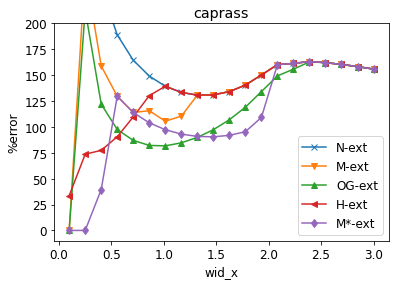

In [ ]:
title="caprass"
vars ="x[4]"
func = "2 + 4*x[0]^2 - 10*x[2]*x[1] + 4*x[2]*x[0]^2*x[1] - 10*x[1]^2 + 2*x[2]*x[1]^3 + 4*x[0]*x[3] - x[0]^3*x[3] + 4*x[0]*x[1]^2*x[3]"


#comparison(vars, func, min_mid=-2., max_mid=2.,  wbox=0.5, n_slices=20)
comparison_w(title, vars, func, mid=1.2, min_w=0.1,  max_w=3.0, n_slices=20, ylim=[-10,200])

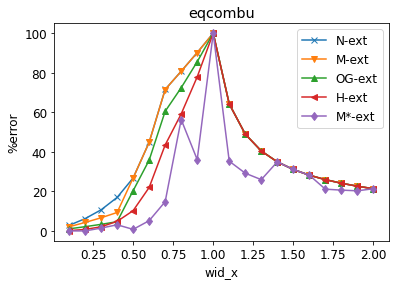

In [ ]:
["eqcombu","x[5]","x[0] + 0.00000044975*x[1] + 2*x[0]*x[1] + 0.0000028845*x[1]^2 + 0.0005451766686*x[1]*x[2] + x[1]*x[2]^2 + 0.00003407354179*x[1]*x[3] - 10*x[4]"]

title="eqcombu"
vars ="x[5]"
func = "x[0] + 0.00000044975*x[1] + 2*x[0]*x[1] + 0.0000028845*x[1]^2 + 0.0005451766686*x[1]*x[2] + x[1]*x[2]^2 + 0.00003407354179*x[1]*x[3] - 10*x[4]"

import matplotlib
matplotlib.rcParams.update({'font.size': 12})
#comparison(vars, func, min_mid=-2., max_mid=2.,  wbox=0.5, n_slices=20)
comparison_w(title, vars, func, mid=-0.5, min_w=0.1,  max_w=2.0, n_slices=20)

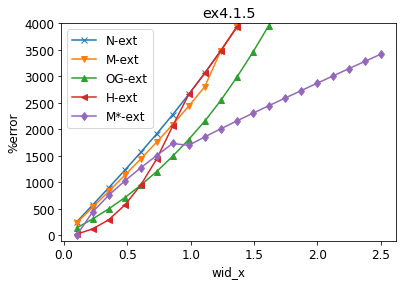

In [ ]:
title="ex4.1.5"
vars ="x[2]"
func = "2*x[0]^2 - 1.05*x[0]^4 + 0.166666666666667*x[0]^6 - x[0]*x[1] + x[1]^2"
#comparison(vars, func, min_mid=-2., max_mid=2.,  wbox=0.1, n_slices=20)
comparison_w(title, vars, func, mid=1.75, min_w=0.1,  max_w=2.5, n_slices=20, ylim=[-100,4000])

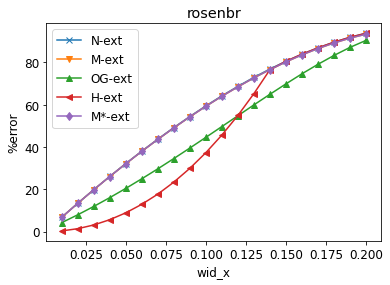

In [ ]:
title="rosenbr"
vars ="x[10]"
func = "100*(x[1]^2-x[0])^2 + (1-x[0])^2 + 100*(x[2]^2-x[1])^2 + (1-x[1])^2 + 100*(x[3]^2-x[2])^2 + (1-x[2])^2 + 100*(x[4]^2-x[3])^2 + (1-x[3])^2 + 100*(x[5]^2-x[4])^2 + \
(1-x[4])^2 + 100*(x[6]^2-x[5])^2 + (1-x[5])^2 + 100*(x[7]^2-x[6])^2 + (1-x[6])^2 + 100*(x[8]^2-x[7])^2 + (1-x[7])^2 + 100*(x[9]^2-x[8])^2 + (1-x[8])^2"

#comparison(vars, func, min_mid=-2., max_mid=2.,  wbox=0.5, n_slices=20)
comparison_w(title, vars, func, mid=0.5, min_w=0.01,  max_w=0.2, n_slices=20)